Epoch 1, Loss: 0.000008
Epoch 2, Loss: 0.000000
Epoch 3, Loss: 0.000000
Epoch 4, Loss: 0.000001
Epoch 5, Loss: 0.000001
Epoch 6, Loss: 0.000001
Epoch 7, Loss: 0.000001
Epoch 8, Loss: 0.000001
Epoch 9, Loss: 0.000000
Epoch 10, Loss: 0.000000
Epoch 11, Loss: 0.000000
Epoch 12, Loss: 0.000000
Epoch 13, Loss: 0.000000
Epoch 14, Loss: 0.000000
Epoch 15, Loss: 0.000000
Epoch 16, Loss: 0.000000
Epoch 17, Loss: 0.000000
Epoch 18, Loss: 0.000000
Epoch 19, Loss: 0.000000
Epoch 20, Loss: 0.000000


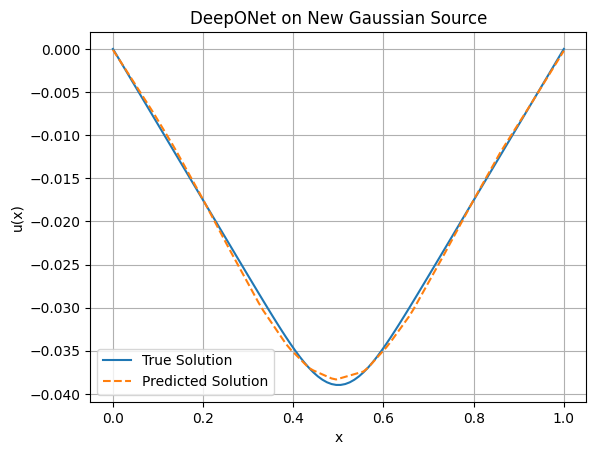

In [30]:
# DeepONet for 1D Heat Conduction with Mixed Function Types

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

# ----------------------
# Data Generation
# ----------------------
def generate_tagged_sources(n_samples, n_points):
    x = np.linspace(0, 1, n_points)
    f_all, u_all, labels = [], [], []
    dx = x[1] - x[0]

    for _ in range(n_samples):
        kind = np.random.choice(["sine", "gauss", "step"])

        if kind == "sine":
            f = np.sin(np.pi * x * np.random.randint(1, 4)) + 0.1 * np.random.randn(n_points)
        elif kind == "gauss":
            c = np.random.uniform(0.2, 0.8)
            w = np.random.uniform(0.05, 0.15)
            f = np.exp(-((x - c)**2) / (2 * w**2))
        elif kind == "step":
            step_idx = np.random.randint(n_points//4, 3*n_points//4)
            f = np.zeros_like(x)
            f[step_idx:] = 1.0
        else:
            continue  # Skip if no valid kind is selected

        # Solve -u'' = f with Dirichlet BCs
        A = np.diag(-2*np.ones(n_points)) + np.diag(np.ones(n_points-1), 1) + np.diag(np.ones(n_points-1), -1)
        A /= dx**2
        A[0, :] = A[-1, :] = 0
        A[0, 0] = A[-1, -1] = 1
        f_bc = f.copy()
        f_bc[0] = f_bc[-1] = 0
        u = np.linalg.solve(A, f_bc)

        f_all.append(f)
        u_all.append(u)
        labels.append(kind)

    return np.array(f_all), np.array(u_all), x, labels

def build_dataset(f_data, u_data, x_grid, labels):
    n_samples, n_points = f_data.shape
    branch_inputs, trunk_inputs, targets, label_list = [], [], [], []

    for i in range(n_samples):
        for j in range(n_points):
            branch_inputs.append(f_data[i])
            trunk_inputs.append([x_grid[j]])
            targets.append(u_data[i][j])
            label_list.append(labels[i])

    return (torch.tensor(branch_inputs, dtype=torch.float32),
            torch.tensor(trunk_inputs, dtype=torch.float32),
            torch.tensor(targets, dtype=torch.float32).unsqueeze(1),
            np.array(label_list))

# ----------------------
# DeepONet Architecture
# ----------------------
class BranchNet(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

class TrunkNet(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

class DeepONet(nn.Module):
    def __init__(self, input_dim_branch, input_dim_trunk, latent_dim):
        super().__init__()
        self.branch = BranchNet(input_dim_branch, latent_dim)
        self.trunk = TrunkNet(input_dim_trunk, latent_dim)

    def forward(self, f_samples, x_points):
        b = self.branch(f_samples)
        t = self.trunk(x_points)
        return torch.sum(b * t, dim=1, keepdim=True)

# ----------------------
# Training + Validation
# ----------------------
n_samples = 100000
n_points = 100
latent_dim = 64

f_train, u_train, x_grid, labels_train = generate_tagged_sources(n_samples, n_points)
f_test, u_test, _, labels_test = generate_tagged_sources(200, n_points)

branch_inputs, trunk_inputs, targets, _ = build_dataset(f_train, u_train, x_grid, labels_train)
train_data = TensorDataset(branch_inputs, trunk_inputs, targets)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

model = DeepONet(input_dim_branch=n_points, input_dim_trunk=1, latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(20):
    model.train()
    total_loss = 0
    for b_in, t_in, y in train_loader:
        pred = model(b_in, t_in)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.6f}")

# ----------------------
# Test on New Function
# ----------------------
def test_new_function(model, f_func, x_grid):
    f_vals = f_func(x_grid)

    def solve_poisson(f, x):
        n = len(x)
        dx = x[1] - x[0]
        A = np.diag(-2*np.ones(n)) + np.diag(np.ones(n-1), 1) + np.diag(np.ones(n-1), -1)
        A /= dx**2
        A[0, :] = A[-1, :] = 0
        A[0, 0] = A[-1, -1] = 1
        f_bc = f.copy()
        f_bc[0] = f_bc[-1] = 0
        return np.linalg.solve(A, f_bc)

    u_true = solve_poisson(f_vals, x_grid)

    with torch.no_grad():
        f_input = torch.tensor(f_vals, dtype=torch.float32).repeat(n_points, 1)
        x_input = torch.tensor(x_grid.reshape(-1, 1), dtype=torch.float32)
        u_pred = model(f_input, x_input).squeeze().numpy()

    plt.plot(x_grid, u_true, label="True Solution")
    plt.plot(x_grid, u_pred, '--', label="Predicted Solution")
    plt.title("DeepONet on New Gaussian Source")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.legend()
    plt.grid(True)
    plt.show()

def gaussian_source(x, center=0.5, width=0.07):
    return np.exp(-((x - center)**2) / (2 * width**2))

# Run test
test_new_function(model, gaussian_source, x_grid)

In [28]:
def cosine_source(x):
    return np.cos(2 * np.pi * x)

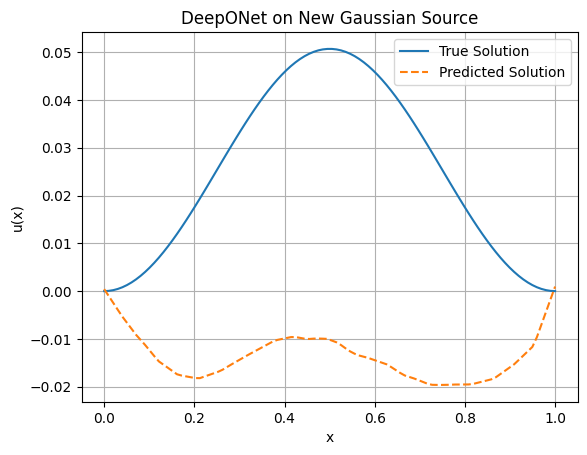

In [29]:
test_new_function(model, cosine_source, x_grid)
